In [5]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute._iterative import IterativeImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from sklearn.impute import SimpleImputer as Imputer, SimpleImputer
from sklearn.neighbors import NearestNeighbors as neigh
from sklearn.neighbors import KNeighborsRegressor as neigh
from sklearn.model_selection import train_test_split as split
from sklearn import metrics
from math import sqrt
import json
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from missingpy import KNNImputer, MissForest



In [6]:
data = pd.read_csv("../data/other_train.csv",index_col=0)

dict_array = []
string = '{"mean_glucose": 9999999,"std_glucose": 9999999,"kurtosis_glucose":9999999,"skewness_glucose":9999999,"mean_oxygen":9999999,"std_oxygen":9999999,"kurtosis_oxygen":9999999,"skewness_oxygen":9999999}'
data.medical_info.apply(lambda x: dict_array.append(json.loads(x.replace("'","\"").replace(":\"",":").replace("\",",",").replace("\"}","}") if isinstance(x,str) else string)))
medical_datas = pd.DataFrame(dict_array)

for item in medical_datas:
    data[item] = medical_datas[item].astype(float)
data = data.drop(columns=['medical_info'])
# print(data)
# data.info()


person = pd.read_csv("../data/personal_train.csv",index_col=0)
# print(person)
# person.info()

In [7]:

data = data.replace({ 9999999 : np.nan },regex=False)
data = data.replace({'^[? ]*$' : np.nan},regex=True)
person = person.replace({'^[? ]*$' : np.nan},regex=True)

In [8]:
numeric = data.select_dtypes(include=['float64'])
categoric = data.select_dtypes(include=['object'])
numeric['name'] = categoric['name']

numeric = numeric.groupby('name').aggregate('mean')
categoric = categoric.groupby('name').aggregate('first')

data = categoric.merge(numeric, on=['name'])

C:\Users\Lukas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
merged_data = pd.merge(person, data, on=['name','address'], how='left')


In [10]:
merged_data = merged_data.replace(['FALSE','F'],'f',regex=True)
merged_data = merged_data.replace(['TRUE','T'],'t',regex=True)

merged_data = merged_data.replace([' <=50K'],'<=50K',regex=True)
merged_data = merged_data.replace([' >50K'],'>50K',regex=True)


merged_data = merged_data.replace([' Other-relative'],' Other_relative',regex=True)
merged_data = merged_data.replace([' Not-in-family'],' Not_in_family',regex=True)
merged_data = merged_data.replace([' Own-child'],' Own_child',regex=True)


for i, row in merged_data.iterrows():
        
    date = parser.parse(merged_data.iloc[i]['date_of_birth'].split(' ')[0])
    day = date.day
    month = date.month
    year = date.year
    
    if (year > 2019):
        year = year - 100

    merged_data.at[i,'date_of_birth'] = str(day) + "/" + str(month) + "/" + str(year)
            
    if ((pd.isna(row['age'])) | (row['age'] > 115) | (row['age'] < 0)):
        merged_data.at[i,'age'] = 2019 - year

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 28 columns):
name                3933 non-null object
address             3933 non-null object
age                 3933 non-null float64
sex                 3933 non-null object
date_of_birth       3933 non-null object
race                3933 non-null object
marital-status      3933 non-null object
occupation          3703 non-null object
pregnant            3931 non-null object
relationship        3932 non-null object
education           3933 non-null object
income              3932 non-null object
native-country      3872 non-null object
workclass           3341 non-null object
education-num       3933 non-null float64
capital-gain        3933 non-null float64
fnlwgt              3932 non-null float64
class               3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
mean_glucose        3932 non-null float64
std_glucose         3932

In [11]:
# Remove outliers which can be probably not use
# print(merged_data['education-num'].value_counts())
# sns.distplot(merged_data['education-num'])

# ## Remove outliers from education-num
# # sns.boxplot(merged_data['education-num'])
# merged_data.loc[merged_data['education-num'] < 5,'education-num'] = np.NaN
# # sns.boxplot(merged_data['education-num'])
# 
# ## Remove outliers from 'capital-gain'
# # sns.boxplot(merged_data['capital-gain'])
# merged_data.loc[merged_data['capital-gain'] > 30000,'capital-gain'] = np.NaN
# # sns.boxplot(merged_data['capital-gain'])
# 
# ## Remove outliers from 'fnlwgt'
# # sns.boxplot(merged_data['fnlwgt'])
# merged_data.loc[merged_data['fnlwgt'] > 800000,'fnlwgt'] = np.NaN
# # sns.boxplot(merged_data['fnlwgt'])
# 
# ## Remove outliers from 'hours-per-week'
# # sns.boxplot(merged_data['hours-per-week'])
# merged_data.loc[(merged_data['hours-per-week'] > 57) | (merged_data['hours-per-week'] < 8),'hours-per-week'] = np.NaN
# # sns.boxplot(merged_data['hours-per-week'])

In [12]:
# Remove outliers on floats datas

## Remove outliers from 'kurtosis_glucose'
column = 'kurtosis_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 6) | (merged_data[column] < -1)
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'mean_glucose'
column = 'mean_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 150)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'mean_oxygen'
column = 'mean_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 120)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'kurtosis_oxygen'
column = 'kurtosis_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 20)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'skewness_glucose'
column = 'skewness_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 40)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'skewness_oxygen'
column = 'skewness_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 350)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'std_glucose'
column = 'std_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 62) 
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'std_oxygen'
column = 'std_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 80)  
merged_data.loc[mask ,column] = np.NaN


In [13]:
# Divide datas into 3 category

old = merged_data
merged_data = merged_data.drop(columns=['class'])

numeric = merged_data.select_dtypes(include=['float64'])
numeric1 = numeric.iloc[:,:7].columns
print(numeric1)
numeric2 = numeric.iloc[:,7:].columns
print(numeric2)        
categoric = merged_data.select_dtypes(include=['object']).columns
print(categoric)

Index(['age', 'education-num', 'capital-gain', 'fnlwgt', 'hours-per-week',
       'capital-loss', 'mean_glucose'],
      dtype='object')
Index(['std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen',
       'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'],
      dtype='object')
Index(['name', 'address', 'sex', 'date_of_birth', 'race', 'marital-status',
       'occupation', 'pregnant', 'relationship', 'education', 'income',
       'native-country', 'workclass'],
      dtype='object')


In [14]:
# Apply pipeline in category 

numeric_transformer1 = Pipeline(steps=[('imputer',MissForest(missing_values=np.NaN, max_iter=10, # Nahradenie nulovych hodnot pomocou MissForest
                                                             decreasing=False, copy=False)), 
                                      ('powerTransformer',PowerTransformer(method='yeo-johnson',
                                                                           copy=False)) # Transformuje dat aby boli viac z Gaussoveho rozdelenia
                                       ])
numeric_transformer2 = Pipeline(steps=[('imputer',KNNImputer(missing_values=np.NaN, n_neighbors=5, # Nahradenie nulovych hodnot pomocou KNN
                                                              weights='distance')), 
                                     # ('RobustScaler',StandardScaler())    # 
                                       ])
categoric_transormer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent'))]) # Nahradenie nulovych hodnot pomocou najcastejsich hodnot
                                      # ('onehot',OneHotEncoder(handle_unknown='ignore'))])
preproccesors = ColumnTransformer(transformers=[('Cat', categoric_transormer, categoric),
                                                ('Num1', numeric_transformer1, numeric1),
                                                ('Num2', numeric_transformer2, numeric2)
                                                ])


In [15]:
# Execute pipeline steps

pipeline = Pipeline(steps=[('preproccesors', preproccesors)])
pipeline_datas = pipeline.fit_transform(merged_data)

Iteration: 0
Iteration: 1
Iteration: 2


C:\Users\Lukas\Anaconda3\lib\site-packages\missingpy\knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
C:\Users\Lukas\Anaconda3\lib\site-packages\missingpy\knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
C:\Users\Lukas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Lukas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Lukas\Anaconda3\lib\site-packages\missing

In [16]:
# Show mereged datas

merged_data = pd.DataFrame(pipeline_datas,columns=merged_data.columns)
print(merged_data)


                     name                                            address  \
0         Roscoe Bohannon  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...   
1            Ernest Kline  391 Ball Road Suite 961\r\nflowersborough, IN ...   
2         Harold Hendriks     8702 Vincent Square\r\nNew Jerryfurt, CO 30614   
3          Randy Baptiste     2751 Harris Crossroad\r\nWest Ashley, CA 30311   
4         Anthony Colucci  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...   
...                   ...                                                ...   
3928      Clair Pinkleton             8582 Lee Roads\r\nCostaburgh, SC 21897   
3929         William Pope  68430 Erik terrace Suite 279\r\nPort Adamborou...   
3930         Jared Kinsey                 Unit 8416 Box 3801\r\nDPO AE 31166   
3931     frederick Lawley   34420 Brian Stream\r\nLake Michaeltown, MS 01832   
3932  Adalberto Daughters                 Unit 7931 Box 0601\r\nDPO AE 50505   

          age         sex        date_o

In [36]:
# merged_data['age'] = merged_data['age'].astype(np.float64)
merged_data['education-num'] = merged_data['education-num'].astype(np.float64)
merged_data['capital-gain'] = merged_data['capital-gain'].astype(np.float64)
merged_data['fnlwgt'] = merged_data['fnlwgt'].astype(np.float64)
# merged_data['class'] = merged_data['class'].astype(np.float64)
merged_data['hours-per-week'] = merged_data['hours-per-week'].astype(np.float64)
merged_data['capital-loss'] = merged_data['capital-loss'].astype(np.float64)
merged_data['mean_glucose'] = merged_data['mean_glucose'].astype(np.float64)
merged_data['std_glucose'] = merged_data['std_glucose'].astype(np.float64)
merged_data['kurtosis_glucose'] = merged_data['kurtosis_glucose'].astype(np.float64)
merged_data['skewness_glucose'] = merged_data['skewness_glucose'].astype(np.float64)
merged_data['mean_oxygen'] = merged_data['mean_oxygen'].astype(np.float64)
merged_data['std_oxygen'] = merged_data['std_oxygen'].astype(np.float64)
merged_data['kurtosis_oxygen'] = merged_data['kurtosis_oxygen'].astype(np.float64)
merged_data['skewness_oxygen'] = merged_data['skewness_oxygen'].astype(np.float64)
print(merged_data)

                     name                                            address  \
0         Roscoe Bohannon  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...   
1            Ernest Kline  391 Ball Road Suite 961\r\nflowersborough, IN ...   
2         Harold Hendriks     8702 Vincent Square\r\nNew Jerryfurt, CO 30614   
3          Randy Baptiste     2751 Harris Crossroad\r\nWest Ashley, CA 30311   
4         Anthony Colucci  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...   
...                   ...                                                ...   
3928      Clair Pinkleton             8582 Lee Roads\r\nCostaburgh, SC 21897   
3929         William Pope  68430 Erik terrace Suite 279\r\nPort Adamborou...   
3930         Jared Kinsey                 Unit 8416 Box 3801\r\nDPO AE 31166   
3931     frederick Lawley   34420 Brian Stream\r\nLake Michaeltown, MS 01832   
3932  Adalberto Daughters                 Unit 7931 Box 0601\r\nDPO AE 50505   

          age         sex        date_o

In [40]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 27 columns):
name                3933 non-null object
address             3933 non-null object
age                 3933 non-null object
sex                 3933 non-null object
date_of_birth       3933 non-null object
race                3933 non-null object
marital-status      3933 non-null object
occupation          3933 non-null object
pregnant            3933 non-null object
relationship        3933 non-null object
education           3933 non-null object
income              3933 non-null object
native-country      3933 non-null object
workclass           3933 non-null object
education-num       3933 non-null float64
capital-gain        3933 non-null float64
fnlwgt              3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3933 non-null float64
mean_glucose        3933 non-null float64
std_glucose         3933 non-null float64
kurtosis_glucose    3933 

In [41]:
merged_data.describe(include="all")

,name,address,age,sex,date_of_birth,race,marital-status,occupation,pregnant,relationship,...,hours-per-week,capital-loss,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
count,3933,3933,3933,3933,3933,3933,3933,3933,3933,3933,...,3.933000e+03,3.933000e+03,3.933000e+03,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000
unique,3933,3933,2,3458,5,6,14,2,6,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,francis Duong,USCGC Burke\r\nfPO AP 02596,Male,25/9/1969,White,Married-civ-spouse,Craft-repair,f,Husband,HS-grad,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,2664,4,3369,1814,770,3850,1597,1292,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.671686e-16,-2.948880e-16,-4.087473e-17,44.981171,0.902339,3.823568,16.150766,30.273655,7.234988,83.424734
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000127e+00,1.000127e+00,1.000127e+00,7.238813,1.470755,8.372301,27.685820,20.515547,4.463499,81.307875
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.083763e+00,-2.271658e-01,-2.048883e+00,25.695250,-0.944764,-1.755332,0.213211,7.370432,-2.597872,-1.976976
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.960806e-02,-2.271658e-01,-6.276687e-01,40.124470,0.074552,-0.119966,2.061873,15.029503,3.602677,12.289702
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.960806e-02,-2.271658e-01,1.822986e-01,45.820717,0.312617,0.373828,3.226589,20.522914,7.714907,67.432595
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.611692e-01,-2.271658e-01,7.372106e-01,50.264563,0.790273,2.081514,12.603679,42.651010,10.195937,125.216984


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002661167CA90>]],
      dtype=object)

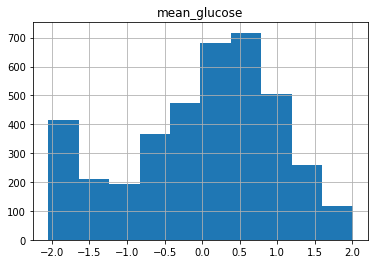

In [37]:
merged_data.hist('mean_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000266112B69E8>]],
      dtype=object)

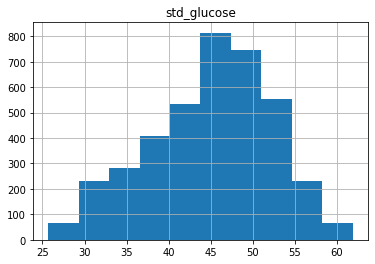

In [27]:
merged_data.hist('std_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026611356550>]],
      dtype=object)

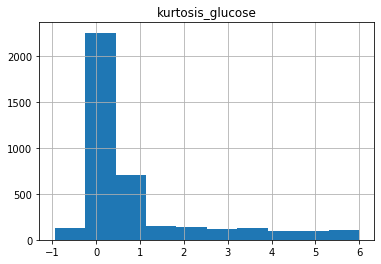

In [28]:
merged_data.hist('kurtosis_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026611404358>]],
      dtype=object)

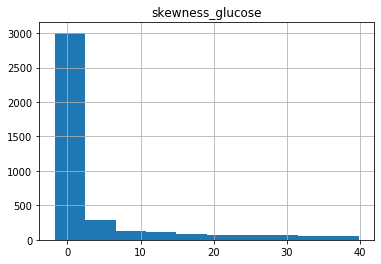

In [29]:
merged_data.hist('skewness_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002661147D438>]],
      dtype=object)

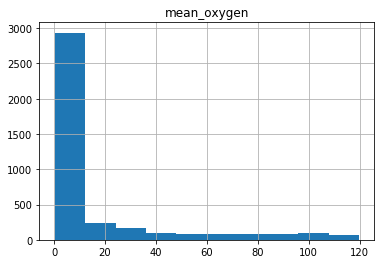

In [30]:
merged_data.hist('mean_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000266114FFC88>]],
      dtype=object)

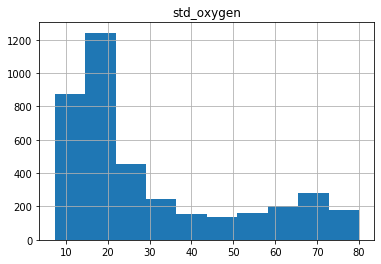

In [31]:
merged_data.hist('std_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002661152BFD0>]],
      dtype=object)

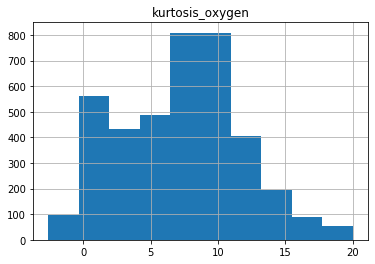

In [32]:
merged_data.hist('kurtosis_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002661160AFD0>]],
      dtype=object)

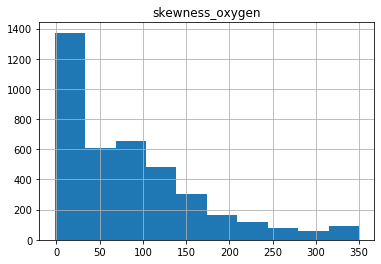

In [33]:
merged_data.hist('skewness_oxygen')

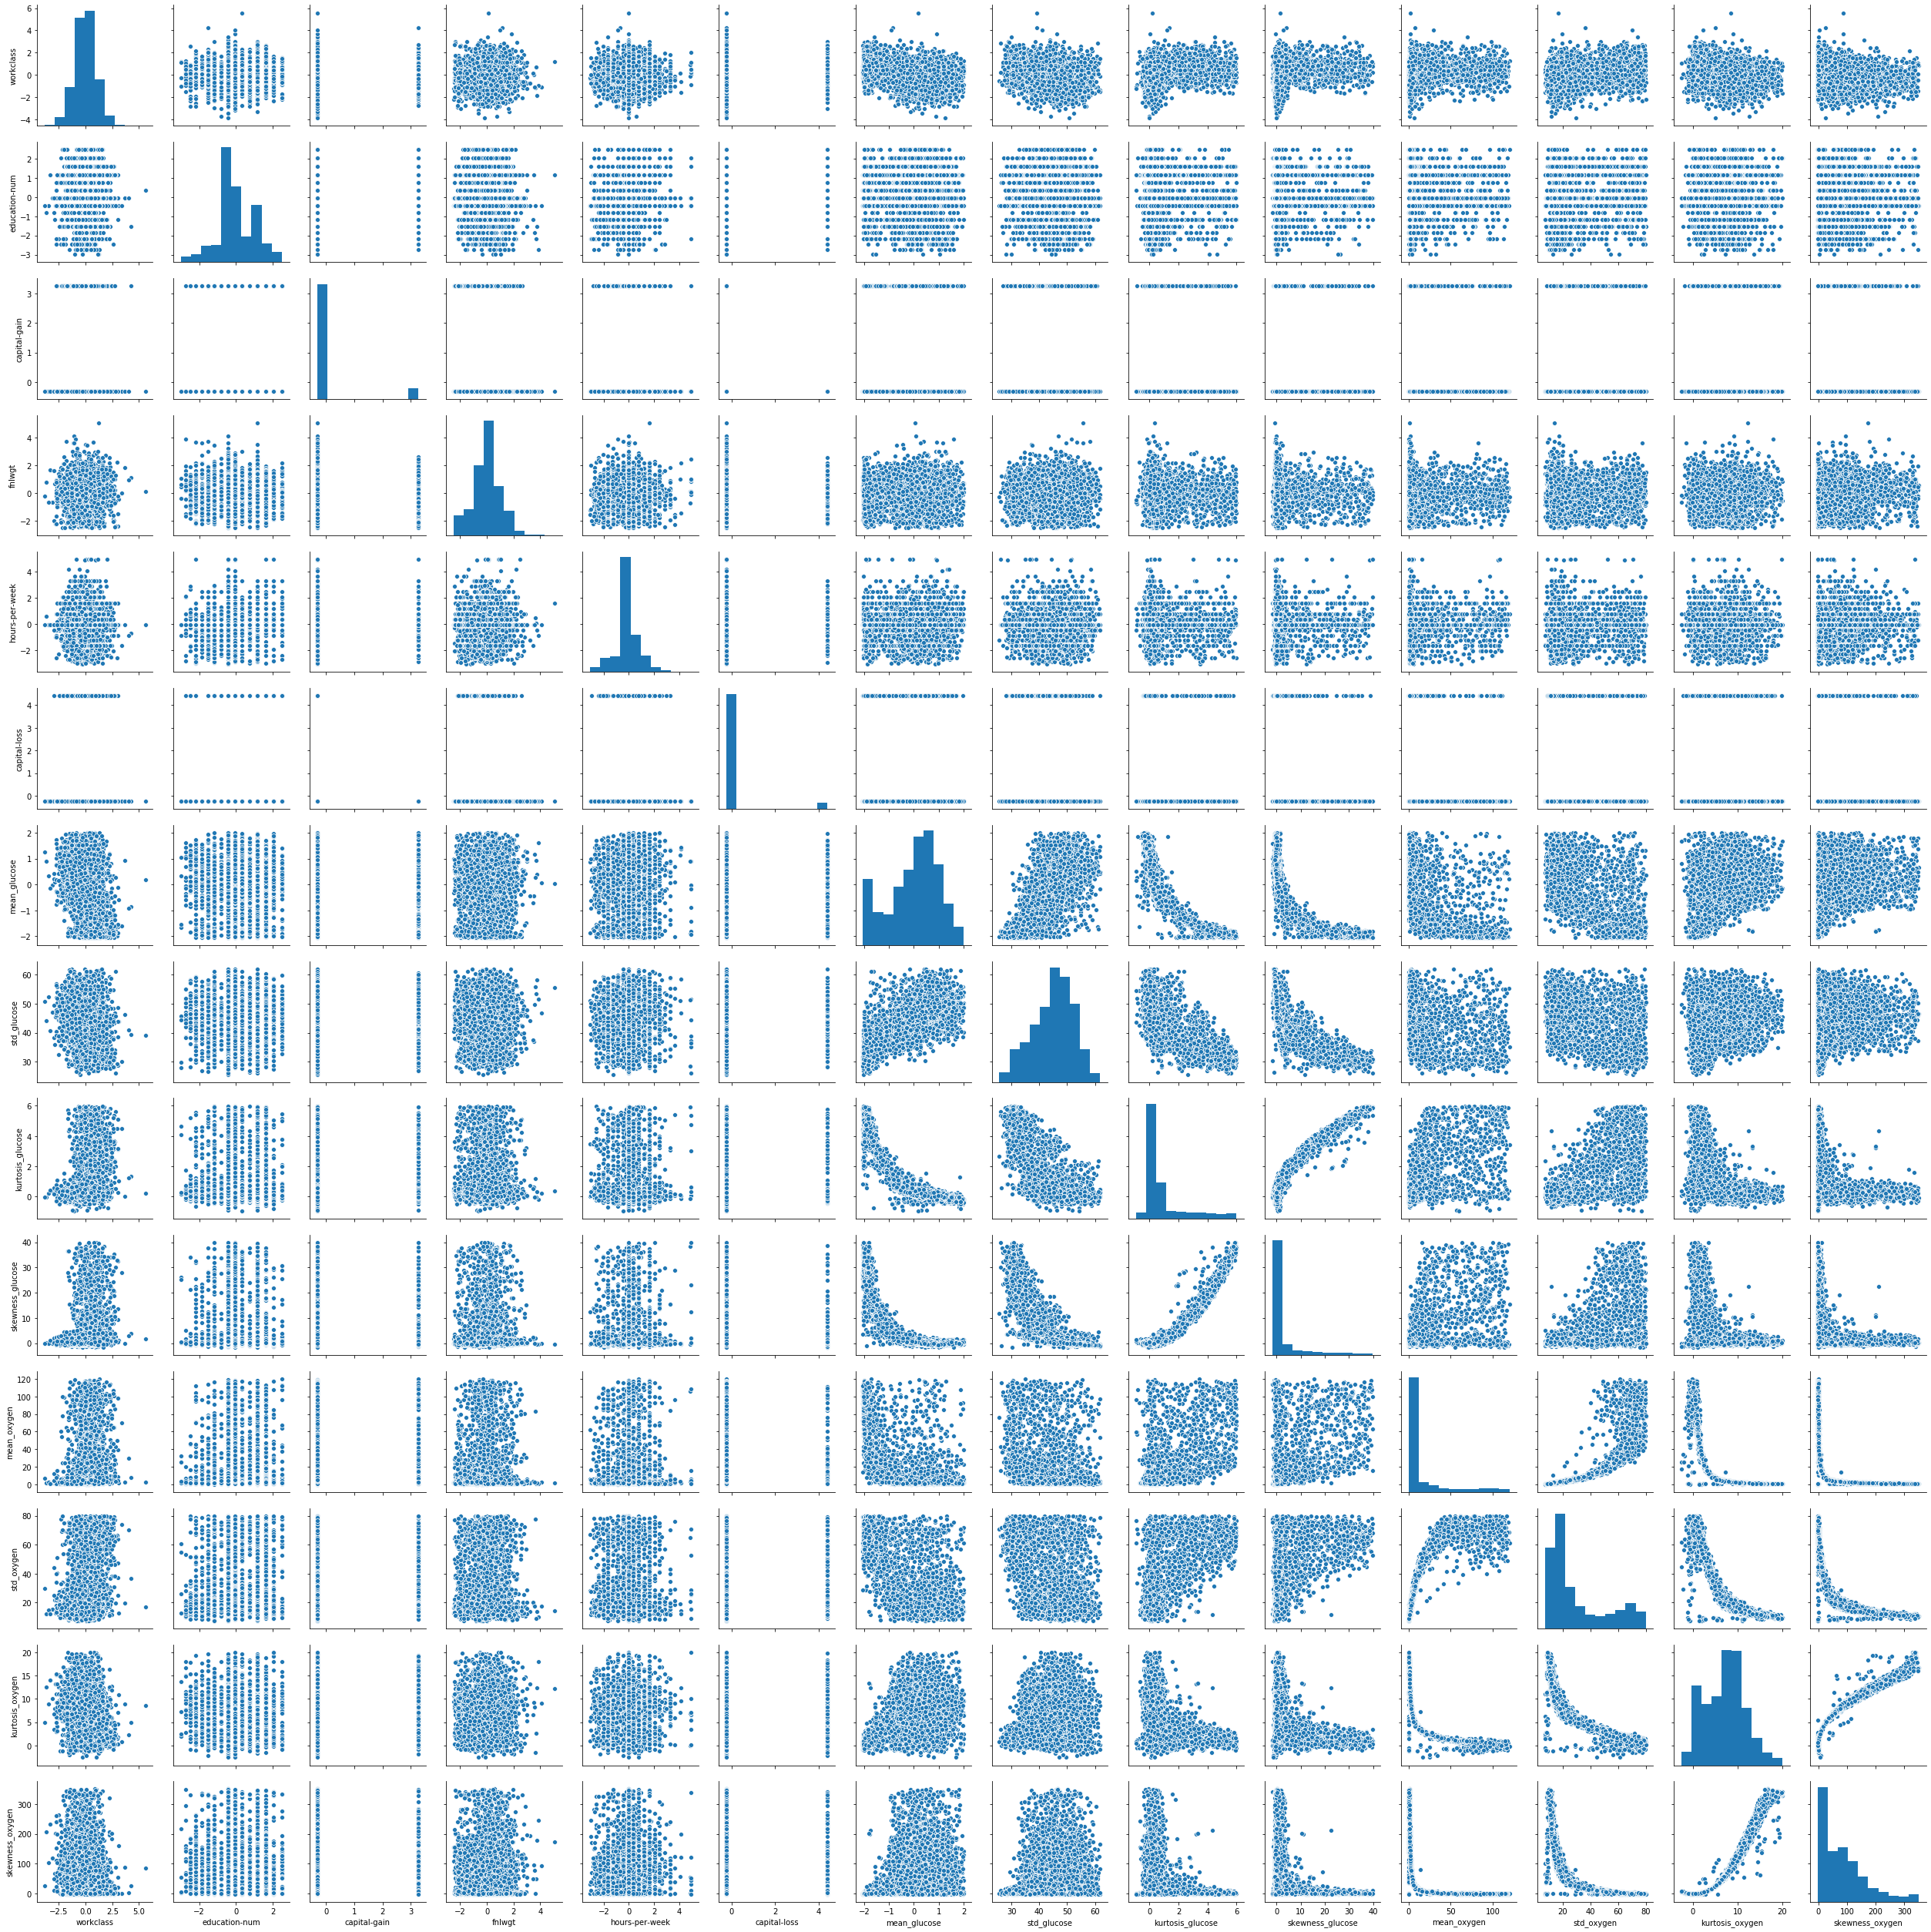

In [43]:
sns.pairplot(merged_data)

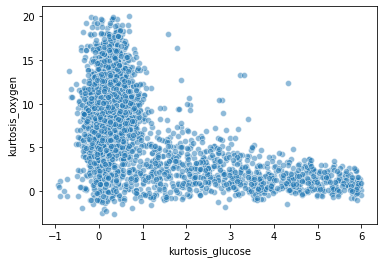

In [44]:
sns.scatterplot(x=merged_data['kurtosis_glucose'], y=merged_data['kurtosis_oxygen'], alpha=0.5)

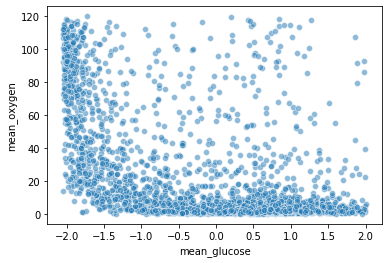

In [45]:
sns.scatterplot(x=merged_data['mean_glucose'], y=merged_data['mean_oxygen'], alpha=0.5)

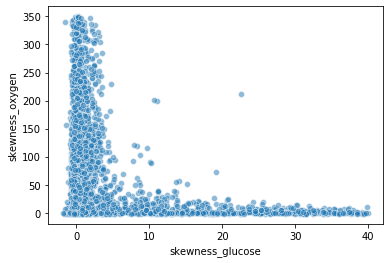

In [46]:
sns.scatterplot(x=merged_data['skewness_glucose'], y=merged_data['skewness_oxygen'], alpha=0.5)

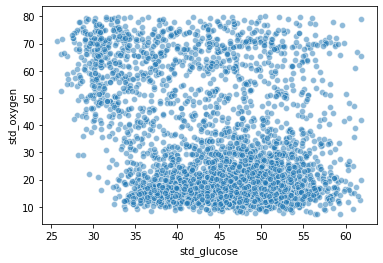

In [47]:
sns.scatterplot(x=merged_data['std_glucose'], y=merged_data['std_oxygen'], alpha=0.5)

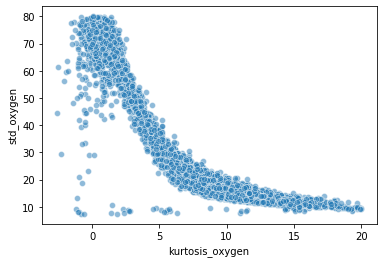

In [48]:
sns.scatterplot(x=merged_data['kurtosis_oxygen'], y=merged_data['std_oxygen'], alpha=0.5)

In [50]:
merged_data.corr()

,education-num,capital-gain,fnlwgt,hours-per-week,capital-loss,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
education-num,1.000000,0.128266,-0.029447,0.137118,0.067128,-0.044120,-0.020247,0.031144,0.027031,0.048545,0.046618,-0.033464,-0.020831
capital-gain,0.128266,1.000000,-0.026340,0.078399,-0.069768,-0.000365,0.005057,-0.001159,0.002176,0.023034,0.022169,-0.011721,-0.006427
fnlwgt,-0.029447,-0.026340,1.000000,-0.012071,-0.005802,0.003857,-0.001372,-0.016946,-0.015200,-0.000356,-0.004645,0.018085,0.022550
hours-per-week,0.137118,0.078399,-0.012071,1.000000,0.051564,0.001708,-0.009017,0.010855,0.018762,0.021038,0.006951,-0.003175,0.001451
capital-loss,0.067128,-0.069768,-0.005802,0.051564,1.000000,0.010464,0.014277,-0.009126,-0.013236,-0.012145,-0.008110,0.024735,0.030482
mean_glucose,-0.044120,-0.000365,0.003857,0.001708,0.010464,1.000000,0.659365,-0.847172,-0.751439,-0.543259,-0.565053,0.458904,0.349215
std_glucose,-0.020247,0.005057,-0.001372,-0.009017,0.014277,0.659365,1.000000,-0.659722,-0.689762,-0.317074,-0.345467,0.262401,0.203723
kurtosis_glucose,0.031144,-0.001159,-0.016946,0.010855,-0.009126,-0.847172,-0.659722,1.000000,0.959100,0.645187,0.667613,-0.554996,-0.426386
skewness_glucose,0.027031,0.002176,-0.015200,0.018762,-0.013236,-0.751439,-0.689762,0.959100,1.000000,0.605250,0.608113,-0.506425,-0.387863
mean_oxygen,0.048545,0.023034,-0.000356,0.021038,-0.012145,-0.543259,-0.317074,0.645187,0.605250,1.000000,0.841879,-0.718767,-0.516701


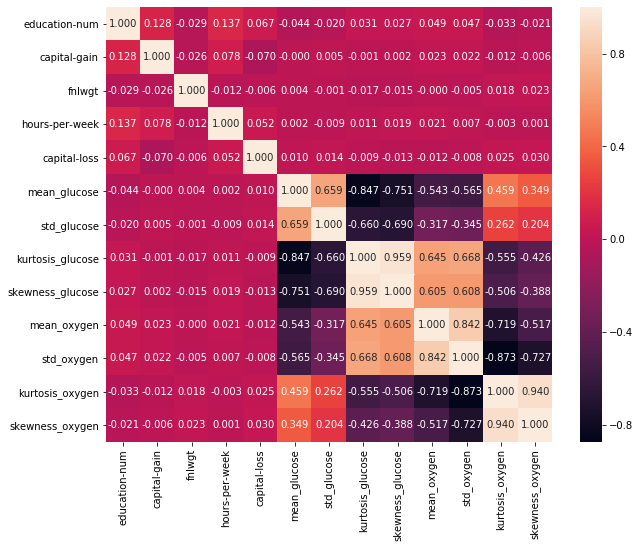

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(merged_data.corr(), ax=ax, annot=True, fmt=".3f")